In [25]:
import msprime # for coalescence simulation
import os # operating system module
import pandas as pd # for working with tables
import datetime # for displaying data and time
import sys # system 
from IPython.display import SVG, display # for displaying SVG files
import io # manages input and output
import tskit # tree sequence tool kit: for building and manipulating trees
import numpy as np # for calculations
import matplotlib.pyplot as plt # for plotting and saving plots
import seaborn as sns # for plotting histograms
import cairosvg # for saving trees as PDF 

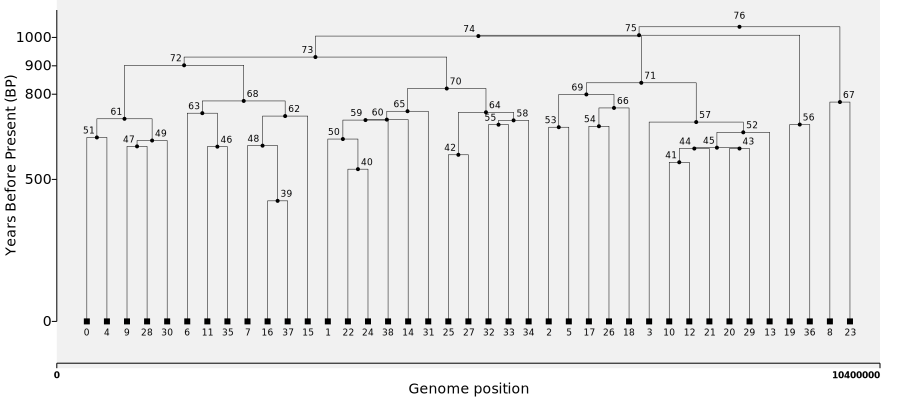

In [28]:
## global parameters

# number of replicates
numRep = 1000

mu = 0.76e-9 # Y-chr mutation rate per site per year, Fu et al. 2014;

# set generation time
genTime = 30 # same as the generation time used by Zerjal et al. 2003

# emergence of C2* (C3*) lineage 
lineageOrigin = 1000 # years BP, based on Zerjal et al. 2003

# C2 expansion start time 
expansionStart = 819  # years BP, corresponding to the year 1206, when Temüjin was elected Genghis Khan. 

# current pop size or effective pop size
nModern = 500_000  # a conservative number of 500K is used for Ne.

# founder pop size
nFounder = 10  # number of males in a small clan, i.e., Borjigin

# create an empty numpy array T that will be used for
# storing tree summary info
T = np.zeros(num_rep)

# perform the simulations

def sim_medieval_scenario(num_replicates = num_rep):
    
    # convert time from years to generations
    gen_expansionStart = expansionStart / genTime
    
    # calculate growth rate from the Mongol Empire to modern times
    r_expansion = np.log( nModern / nFounder) / gen_expansionStart
    
    ## demographic info
    
    # set up demography
    demography = msprime.Demography()
    
    # phase 3: expansion (in forward time: 800 BP to modern)
    demography.add_population(
        name = "C2_Lineage",
        initial_size = nModern,
        growth_rate = r_expansion
    )
    
    # phase 2: emergence of Mongolian founders (from 1000 BP to 800 BP)
    # r was constant prior to the Mongol Empire
    # so growth_rate=0
    demography.add_population_parameters_change(
        time = gen_expansionStart,
        growth_rate = 0, # constant pop size before expansion
        initial_size = nFounder,
        population = "C2_Lineage"
    )
    
    # phase 1: emergence of C2-F1918
    # to coalesce all clades at around 1000 years ago
    # we need to use initial_size=0.5, that is Ne equals 0.5;
    demography.add_population_parameters_change(
        time = lineageOrigin / genTime,
        initial_size = 0.5,
        population = "C2_Lineage"
    )
    
    ## carry out the simulation with 1000 replicates
    # This returns a GENERATOR if num_replicates is passed
    return msprime.sim_ancestry(
        samples = {"C2_Lineage": 39}, # same number of samples as the Y-chr tree in the manuscript
        demography = demography,
        ploidy = 1,
        sequence_length = 10.4e6, # accessible Y-chr size for phylogenetics, Poznik et al. 2013
                                # ~62 Mb, based on T2T Y-chr study (Rhie et al. 2023)
        num_replicates = numRep 
    )
    

## Run the script and get the results

# run the simulation with 1000 replicates
replicates = sim_medieval_scenario()


# place holder for the first tree
first_ts = None

# for storing clade info
allClades = []

# extract tree info
# and store them in T, tmrcas, and all_clades
for i, ts in enumerate(replicates):
    
    # get the tree
    tree = ts.first()
    
    # store the first tree for plotting
    if i == 0:
        first_ts = ts
    
    # store tmrca values as years
    # instead of as default generations
    # gen_time = 25 years
    T[i] = tree.time(tree.root) * genTime
    
    # for extracting clade info
    # by looping through all internal nodes
    for u in tree.nodes():
            if tree.is_leaf(u):
                continue
            # get tmrca of each internal nodes in years
            tmrca = tree.time(u) * genTime
  
            # classify clades based on TMRCA
            # Expanded nodes are the star cluster lineages
            # Founder nodes are the ancestral nodes
            cladeType = "Expanded" if tmrca < (expansionStart + 50) else "Founder"

            # add the clade info to the allClades list   
            allClades.append({
                "Replicate_ID": i,
                "TMRCA_Years_BP": tmrca,
                "Type": cladeType
            }) 
    
# store clade info in a pandas dataframe       
clade_data = pd.DataFrame(allClades)

# subset the clade_data by Type.
expanded_data = clade_data[clade_data["Type"] == "Expanded"]
founder_data = clade_data[clade_data["Type"] == "Founder"]

# find mean tmrca
mean_expanded = expanded_data["TMRCA_Years_BP"].mean()
mean_founder = founder_data["TMRCA_Years_BP"].mean()

## function for plotting summary
def plot_summary(df, num_replicates = numRep):
    # create figure and axes objects
    # figure info will be stored in fig object
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # the contribution of each point to Y-axis height is 1/replicates;
    weights = np.ones(len(df)) / numRep
    
    # plot histogram with Kernel Density Estimation (KDE), i.e., density distribution
    # stat="count" with weights gives us the average count per bin
    sns.histplot(
        data = df, 
        x = "TMRCA_Years_BP", 
        hue = "Type", 
        weights = weights,
        bins = 80,
        kde = True, # adds the smooth density line
        palette = {"Expanded": "dodgerblue", "Founder": "peru"},
        element = "step",
        alpha = 0.5,
        ax = ax  # tells seaborn to draw on the variable
    )
    
    # add ref lines
    ax.axvline(x = mean_expanded, color='midnightblue', linestyle='--', linewidth=2, label="Mongol Expansion (800 BP)")
    ax.axvline(x = mean_founder, color='brown', linestyle='--', linewidth=2, label="Medieval Origin (1000 BP)")
    
    # additional formatting
    ax.set_title(f"Coalescence Events in the Medieval Scenario ({numRep} replicates)", fontsize=14)
    ax.set_xlabel("Years Before Present", fontsize = 12)
    ax.set_ylabel("Average Coalescence Events per Simulation", fontsize = 12)
    ax.legend()
    ax.grid(alpha = 0.2)
    
    # annotate the plot to explain the peaks
    ax.text((expansionStart - 410), 1.5, 
              # :.0f for rounding to zero decimal place; :.2f for two decimal places
             f"Expansion during\n the Mongol Empire,\n with a mean TMRCA\n of {mean_expanded:.0f} years",
             color='midnightblue')
    ax.text((lineageOrigin - 30), 1, 
             f"Early Medieval\n   Origin,\n with a mean TMRCA\n of {mean_founder:.0f} years",
             color='brown')
    
    # close the figure before displaying
    plt.close(fig)
    
    # return the figure object
    return fig
 

# convert generations into years 
# for all trees
#gen_time = 25
tables = first_ts.dump_tables()
tables.nodes.time *= genTime  # multiply by 25 to get years
ts_years = tables.tree_sequence()

# set the style
# .sym { r: 2; } # for changing node size
# .x-axis .tick:last-of-type text { text-anchor: end; } 
style = """
    .sym { r: 2; } 
    .node { r: 2; }
    .node > .lab { font-size: 9px; } 
    .edge { stroke-width: 0.5px; }
    .leaf > .lab { font-size: 9px; }
    .x-axis .tick text { font-size: 9px; }
    .x-axis .tick:last-of-type text { text-anchor: end; }
"""

# define exactly which years you want to show on the axis
important_dates = [0, 500, 800, 900, 1000]

mideval_tree = ts_years.draw_svg(
    size=(900, 400), 
    style=style,
    y_axis=True, 
    y_label="Years Before Present (BP)",
    y_ticks=important_dates 
)

display(SVG(mideval_tree))   

# save the tree as a PDF file
cairosvg.svg2pdf(bytestring = mideval_tree.encode('utf-8'), 
                 write_to = "mideval_tree.pdf")


# generate the summary figure
mideval_summary = plot_summary(clade_data)

# display
mideval_summary

# save the summary as a PDF file
# via Matplotlib
mideval_summary.savefig("mideval_summary.pdf", 
                        bbox_inches = 'tight')




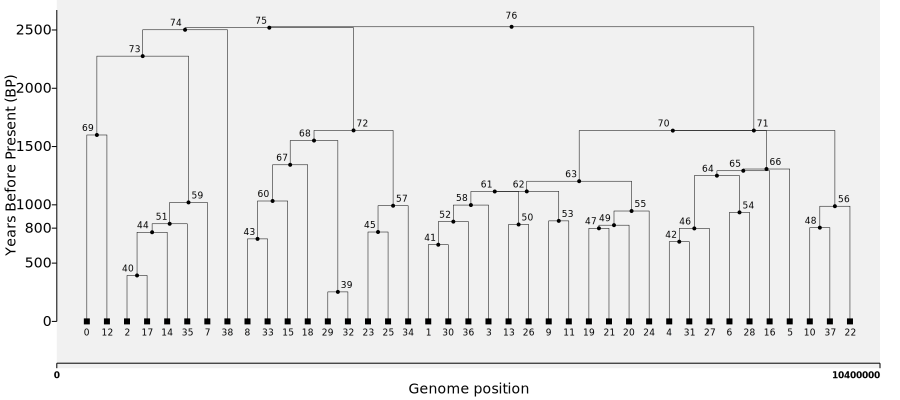

In [29]:
## global parameters

# number of replicates
numRep = 1000

mu = 0.76e-9 # Y-chr mutation rate per site per year, Fu et al. 2014;

# set generation time
genTime = 30 # same as the generation time used by Zerjal et al. 2003

# emergence of C2* (C3*) lineage 
lineageOrigin = 2500 # years BP, Iron Age origin

# C2 expansion start time 
expansionStart = 819  # years BP, corresponding to the year 1206, when Temüjin was elected Genghis Khan. 

# current pop size or effective pop size
nModern = 500_000  # effective population size of C2-F1918 males

# founder pop size
nFounder = 100  # number of males in the founder population


## perform the simulations

def sim_iron_age_scenario(num_replicates = numRep):
    
    # convert time from years to generations
    gen_expansionStart = expansionStart / genTime
    
    # calculate growth rate from the Mongol Empire to modern times
    # here we solve for r in the formula of exponential growth: N_final=N_start*e^rt
    r_expansion = np.log( nModern / nFounder) / gen_expansionStart
    
    ## demographic info
    
    # set up demography
    demography = msprime.Demography()
    
    # phase 3: expansion (in forward time: 800 BP to modern)
    demography.add_population(
        name = "C2_Lineage",
        initial_size = nModern,
        growth_rate = r_expansion
    )
    
    # phase 2: emergence of Mongolian founders (from 2500 BP to 800 BP)
    # r was constant prior to the Mongol Empire
    # so growth_rate=0
    demography.add_population_parameters_change(
        time = gen_expansionStart,
        growth_rate = 0, # constant pop size before expansion
        initial_size = nFounder,
        population = "C2_Lineage"
    )
    
    # phase 1: emergence of C2-F1918
    # to coalesce all clades at around 2500 years ago
    # we need to use initial_size=0.5, that is Ne equals 0.5;
    demography.add_population_parameters_change(
        time = lineageOrigin / genTime,
        initial_size = 0.5,
        population = "C2_Lineage"
    )
    
    ## carry out the simulation with 1000 replicates
    # This returns a GENERATOR if num_replicates is passed
    return msprime.sim_ancestry(
        samples = {"C2_Lineage": 39}, # same number of samples as the Y-chr tree in the manuscript
        demography = demography,
        ploidy = 1,
        sequence_length = 10.4e6, # accessible Y-chr size for phylogenetics, Poznik et al. 2013
                                # ~62 Mb, based on T2T Y-chr study (Rhie et al. 2023)
        num_replicates = numRep 
    )
    

## Run the script and get the results

# run the simulation with 1000 replicates
replicates = sim_iron_age_scenario()


# place holder for the first tree
first_ts = None

# for storing clade info
allClades = []

# extract tree info
# and store them in T, tmrcas, and all_clades
for i, ts in enumerate(replicates):
    
    # get the tree
    tree = ts.first()
    
    # store the first tree for plotting
    if i == 0:
        first_ts = ts
    
    # for extracting clade info
    # by looping through all internal nodes
    for u in tree.nodes():
            if tree.is_leaf(u):
                continue
            
            tmrca = tree.time(u) * genTime
            
            # classify clades based on TMRCA
            # Expanded nodes are the star cluster lineages
            # Founder nodes are the ancestral nodes
            cladeType = "Expanded" if tmrca < (expansionStart + 200) else "Founder"

            # add the clade info to the allClades list   
            allClades.append({
                "Replicate_ID": i,
                "TMRCA_Years_BP": tmrca,
                "Type": cladeType
            }) 
    
# store clade info in a pandas dataframe       
clade_data = pd.DataFrame(allClades)

# subset the clade_data by Type.
expanded_data = clade_data[clade_data["Type"] == "Expanded"]
founder_data = clade_data[clade_data["Type"] == "Founder"]

# find mean tmrca
mean_expanded = expanded_data["TMRCA_Years_BP"].mean()
mean_founder = founder_data["TMRCA_Years_BP"].mean()

## function for plotting summary
def plot_summary(df, num_replicates = numRep):
    
    # create figure and axis objects
    # the figure info will be stored in the fig object 
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # the contribution of each point to Y-axis height is 1/replicates;
    weights = np.ones(len(df)) / numRep
    
    # plot histogram with Kernel Density Estimation (KDE), i.e., density distribution
    sns.histplot(
        data = df, 
        x = "TMRCA_Years_BP", 
        hue = "Type", 
        weights = weights,
        bins = 80,
        kde = True, # adds the smooth density line
        palette = {"Expanded": "dodgerblue", "Founder": "peru"},
        element = "step",
        alpha = 0.5,
        ax = ax  # tells the program, seaborn, to draw on our variable
    )
    
    # add ref lines
    # use ax method instead of plt
    ax.axvline(x = mean_expanded, color='midnightblue', linestyle='--', linewidth=2, label="Mongol Expansion (800 BP)")
    ax.axvline(x = mean_founder, color='brown', linestyle='--', linewidth=2, label="Iron Age Origin (2500 BP)")
    
    # additional formatting
    ax.set_title(f"Coalescence Events in the Iron Age Scenario ({numRep} replicates)", fontsize=14)
    ax.set_xlabel("Years Before Present", fontsize = 12)
    ax.set_ylabel("Average Coalescence Events per Simulation", fontsize = 12)
    ax.legend()
    ax.grid(alpha = 0.2)
    
    # annotate the plot to explain the peaks
    ax.text((mean_expanded - 550), 1.5, 
             # :.0f is for zero decimal place; :.2f for two decimal places
             f"Expansion during\n the Mongol Empire,\n with a mean TMRCA\n of {mean_expanded:.0f} years", 
             color='midnightblue')
    ax.text((mean_founder + 20), 1, 
             f"Iron Age Origin,\n with a mean TMRCA\n of {mean_founder:.0f} years", 
             color='brown')
    
    # close the plot before displaying it
    plt.close(fig)
    
    # save the plot as a figure object
    return fig



# convert generations into years 
# for all trees
tables = first_ts.dump_tables()
tables.nodes.time *= genTime  # multiply by genTime (25) to get years
ts_years = tables.tree_sequence()

# set the style
style = """
    .sym { r: 2; } 
    .node { r: 2; }
    .node > .lab { font-size: 9px; } 
    .edge { stroke-width: 0.5px; }
    .leaf > .lab { font-size: 9px; }
    .x-axis .tick text { font-size: 9px; }
    .x-axis .tick:last-of-type text { text-anchor: end; }
"""

# define exactly which years you want to show on the axis
important_dates = [0, 500, 800, 1000, 1500, 2000, 2500]

iron_age_tree = ts_years.draw_svg(
    size=(900, 400), 
    style=style,
    y_axis=True, 
    y_label="Years Before Present (BP)",
    y_ticks=important_dates 
)

display(SVG(iron_age_tree))     

# save the tree as a PDF file
cairosvg.svg2pdf(bytestring = iron_age_tree.encode('utf-8'), 
                 write_to = "iron_age_tree.pdf")


# generate the summary figure
iron_age_summary = plot_summary(clade_data)
iron_age_summary


# save the summary as a PDF file
# via Matplotlib
iron_age_summary.savefig("iron_age_summary.pdf", 
                        bbox_inches = 'tight')


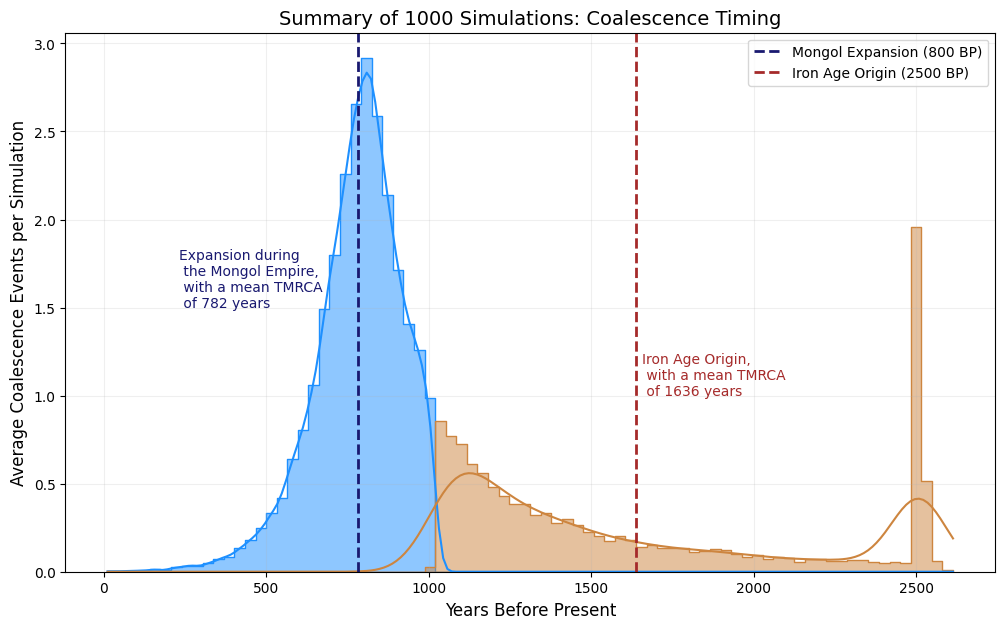

In [19]:
iron_age_summary

In [24]:
display(SVG(mideval_tree))       
display(SVG(iron_age_tree)) 

print(mideval_summary)

print(iron_age_summary)

Figure(1200x700)
Figure(1200x700)
